In [1]:
import xso

In [2]:
import os,sys,inspect
sys.path.insert(1, os.path.join(sys.path[0], '../src'))

import phydra

In [3]:
os.getcwd()

'/home/mazzy/Documents/GitHub/phydra/prototypes'

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
from phydra.components.variables import SV

from phydra.components.fluxes.basic import LinearDecay, LinearExchange, QuadraticDecay, QuadraticExchange
from phydra.components.fluxes.growth_multi_lim import Growth_ML, Eppley_ML, Monod_ML, Steele_ML
from phydra.components.fluxes.grazing import (HollingTypeIII_ResourcesListInput_Consumption2Group,
                                              GrossGrowthEfficiency)
from phydra.components.fluxes.ocean_physics import Mixing_K, SlabUpwelling_KfromGroup, SlabMixing_KfromGroup, SlabSinking

from phydra.components.forcings import GlobalSlabClimatologyForcing

ValueError: ('Failed to pars dims argument for', Attribute(name='grazing', default=NOTHING, validator=None, repr=True, eq=True, eq_key=None, order=True, order_key=None, hash=None, init=True, metadata=mappingproxy({'var_type': <XSOVarType.FLUX: 'flux'>, 'flux_func': <function SizebasedGrazingKernel_Dims.grazing at 0x7fadd85704c0>, 'group': 'graze_matrix', 'group_to_arg': None, 'dims': ('resource', 'consumer'), 'attrs': {'Phydra_store_out': True}, 'description': ''}), type=None, converter=None, kw_only=False, inherited=False, on_setattr=None), 'with dimensions:', ('resource', 'consumer'))

In [6]:
NPZD = xso.create({
    # State variables
    'Nutrient':SV,
    'Phytoplankton':SV,
    'Zooplankton':SV,
    'Detritus':SV,
    
    # Mixing:
    'K':Mixing_K,
    'Upwelling':SlabUpwelling_KfromGroup,
    'Mixing':SlabMixing_KfromGroup,
    'Sinking':SlabSinking,

    # Growth
    'Growth':Growth_ML,
    'Monod':Monod_ML,
    'Steele':Steele_ML,
    'Eppley':Eppley_ML,
    
    # Grazing
    'Grazing':HollingTypeIII_ResourcesListInput_Consumption2Group,
    'GGE':GrossGrowthEfficiency,
    
    # Mortality 
    'PhytoLinMortality':LinearExchange,
    'PhytoQuadMortality':QuadraticExchange,
    'ZooLinMortality':LinearExchange,
    'HigherOrderPred':QuadraticDecay,
    'DetRemineralisation':LinearExchange,

    # Forcings
    'N0':GlobalSlabClimatologyForcing,
    'Tmld':GlobalSlabClimatologyForcing,
    'I0':GlobalSlabClimatologyForcing,
    'MLD':GlobalSlabClimatologyForcing,
    'MLDderiv':GlobalSlabClimatologyForcing,
                     })

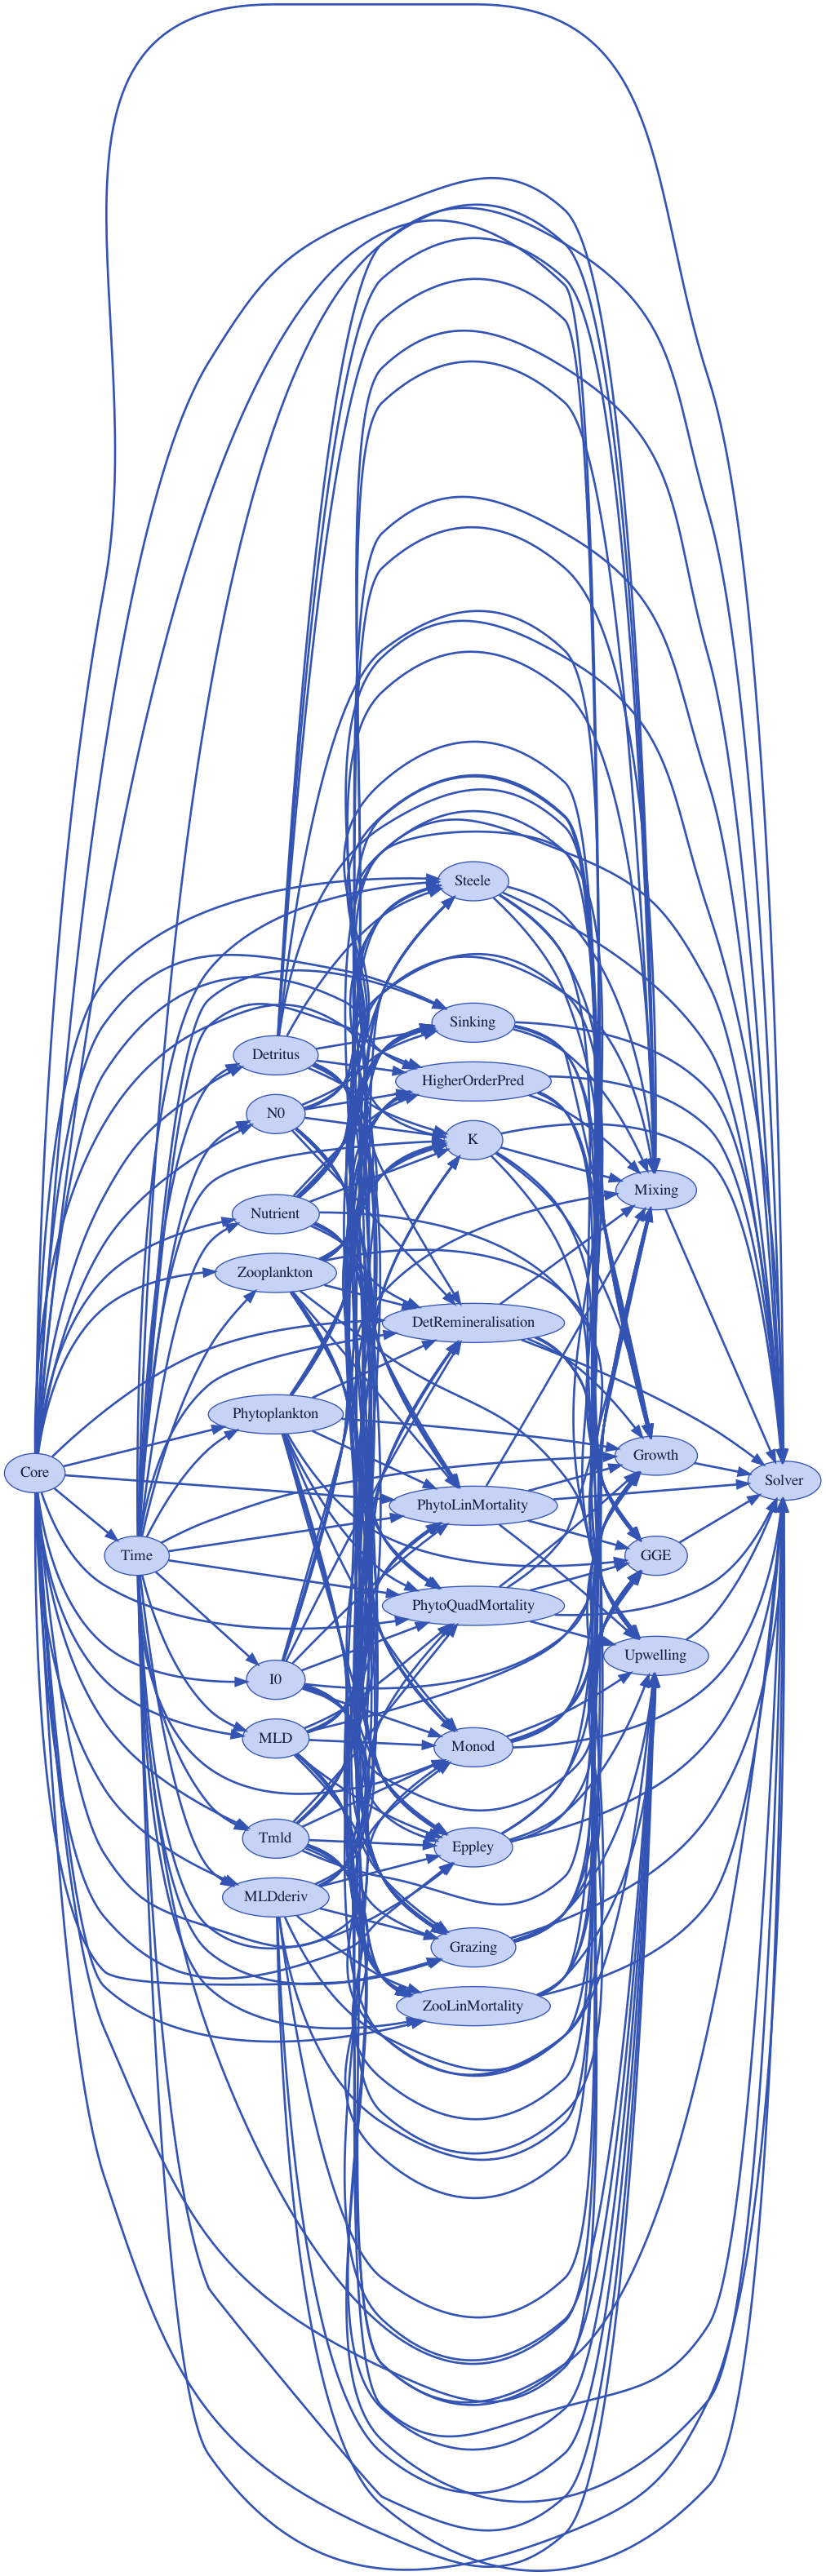

In [7]:
NPZD.visualize()

In [8]:
print(NPZD)

<xsimlab.Model (27 processes, 96 inputs)>
Core
    solver_type              [in]
Time
    time                     [in] ('input_time',) sequence of time ...
Nutrient
    var_label                [in] label / basic state variable
    var_init                 [in] initial value / basic state variable
Phytoplankton
    var_label                [in] label / basic state variable
    var_init                 [in] initial value / basic state variable
Zooplankton
    var_label                [in] label / basic state variable
    var_init                 [in] initial value / basic state variable
Detritus
    var_label                [in] label / basic state variable
    var_init                 [in] initial value / basic state variable
N0
    forcing_label            [in] label / 
    dataset                  [in] Options: 'n0x', 'mld', 'tmld', 'par'
    lat                      [in] constant value of forcing
    lon                      [in] constant value of forcing
    rbb                   

In [9]:
# Set common location of global slab forcing
forcing_location = {'lat':47,'lon':-20,'rbb':2}

odeint_setup = xso.setup('odeint', NPZD,
            time=np.arange(0,365*5),
            input_vars={
                    # State variables
                    'Nutrient':{'var_label':'N','var_init':1.},
                    'Phytoplankton':{'var_label':'P','var_init':1.},
                    'Zooplankton':{'var_label':'Z','var_init':1.},
                    'Detritus':{'var_label':'D','var_init':1.},
                
                    # Mixing:
                    'K':{'mld':'MLD', 'mld_deriv':'MLDderiv', 
                              'kappa':0.13},
                    'Upwelling':{'n':'N', 'n_0':'N0'},
                    'Mixing':{'vars_sink':['P','Z','D']},
                    'Sinking':{'var':'D', 'mld':'MLD', 'rate':6.43},

                    # Growth
                    'Growth':{'consumer':'P', 'resource':'N', 'mu_max':1.,},
                    'Monod':{'resource':'N', 'halfsat':.85},
                    'Steele':{'pigment_biomass':'P','i_0':'I0', 'mld':'MLD',
                          'kw':0.04, 'kc':0.03, 'i_opt':10},
                    'Eppley':{'temp':'Tmld', 'eppley_exp':0.063},

                    # Grazing
                    'Grazing':{'resources':['P','D'], 'consumer':'Z',
                           'feed_prefs':[.67,.33],'Imax':1., 'kZ':.6},
                    'GGE':{'assimilated_consumer':'Z', 'egested_detritus':'D', 'excreted_nutrient':'N', 
                           'epsilon':0.75, 'beta':0.69},

                    # Mortality & sinking
                    'PhytoLinMortality':{'source':'P', 'sink':'D', 'rate':0.1},
                    'PhytoQuadMortality':{'source':'P', 'sink':'D', 'rate':0.01},
                    'ZooLinMortality':{'source':'Z', 'sink':'D', 'rate':0.1},
                    'HigherOrderPred':{'var':'Z', 'rate':0.34},
                    'DetRemineralisation':{'source':'D', 'sink':'N', 'rate':0.1},

                    # Forcings
                    'N0':{**forcing_location, 'forcing_label':'N0', 'dataset':'n0x',
                          'smooth':5, 'k':2, 'deriv':0},
                    'Tmld':{**forcing_location, 'forcing_label':'Tmld', 'dataset':'tmld',
                          'smooth':5, 'k':2, 'deriv':0},
                    'I0':{**forcing_location, 'forcing_label':'I0', 'dataset':'par',
                          'smooth':10, 'k':2, 'deriv':0},
                    'MLD':{**forcing_location, 'forcing_label':'MLD', 'dataset':'mld',
                          'smooth':400, 'k':2, 'deriv':0},
                    'MLDderiv':{**forcing_location, 'forcing_label':'MLDderiv', 'dataset':'mld',
                          'smooth':400, 'k':2, 'deriv':1}
            },
            output_vars="ALL"
            )

In [10]:
print(odeint_setup)

<xarray.Dataset>
Dimensions:                      (clock: 2, input_time: 1825, resources: 2, sinking_vars: 3)
Coordinates:
  * clock                        (clock) int64 0 1
Dimensions without coordinates: input_time, resources, sinking_vars
Data variables: (12/96)
    Nutrient__var_label          <U1 'N'
    Nutrient__var_init           float64 1.0
    Phytoplankton__var_label     <U1 'P'
    Phytoplankton__var_init      float64 1.0
    Zooplankton__var_label       <U1 'Z'
    Zooplankton__var_init        float64 1.0
    ...                           ...
    MLDderiv__dataset            <U3 'mld'
    MLDderiv__smooth             int64 400
    MLDderiv__k                  int64 2
    MLDderiv__deriv              int64 1
    Core__solver_type            <U6 'odeint'
    Time__time                   (input_time) int64 0 1 2 3 ... 1822 1823 1824
Attributes:
    __xsimlab_output_vars__:  Nutrient__var_value,Phytoplankton__var_value,Zo...


In [11]:
with NPZD:
    odeint_out = odeint_setup.xsimlab.run()

initializing model backend
Initializing Model Time
Initializing component Nutrient
Initializing component Phytoplankton
Initializing component Zooplankton
Initializing component Detritus
Initializing component N0
Initializing component I0
Initializing component MLDderiv
Initializing component Tmld
Initializing component MLD
Initializing component K
K_mixing
Initializing component DetRemineralisation
Initializing component PhytoLinMortality
Initializing component Steele
Steele_steele_light_lim
Initializing component HigherOrderPred
Initializing component ZooLinMortality
Initializing component Sinking
Initializing component PhytoQuadMortality
Initializing component Monod
Monod_monod_lim
Initializing component Eppley
Eppley_eppley_growth
Initializing component Grazing
Grazing_grazing
Initializing component Upwelling
Initializing component Mixing
Initializing component Growth
Initializing component GGE
assembling model
SOLVER : <xso.solvers.ODEINTSolver object at 0x158986040>
Model is asse

In [12]:
print(odeint_out)

<xarray.Dataset>
Dimensions:                           (clock: 2, input_time: 1825, resources: 2, sinking_vars: 3, sinking_vars_full: 3, time: 1825)
Coordinates:
  * clock                             (clock) int64 0 1
Dimensions without coordinates: input_time, resources, sinking_vars, sinking_vars_full, time
Data variables: (12/122)
    Core__solver_type                 <U6 'odeint'
    DetRemineralisation__decay_value  (time) float64 0.09917 0.09917 ... 0.04731
    DetRemineralisation__rate         float64 0.1
    DetRemineralisation__sink         <U1 'N'
    DetRemineralisation__source       <U1 'D'
    Detritus__var_init                float64 1.0
    ...                                ...
    ZooLinMortality__rate             float64 0.1
    ZooLinMortality__sink             <U1 'D'
    ZooLinMortality__source           <U1 'Z'
    Zooplankton__var_init             float64 1.0
    Zooplankton__var_label            <U1 'Z'
    Zooplankton__var_value            (time) float64 1.0 0.

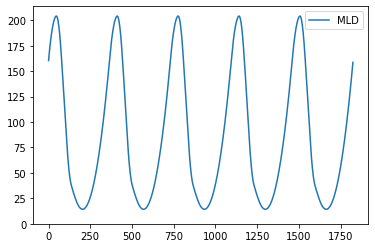

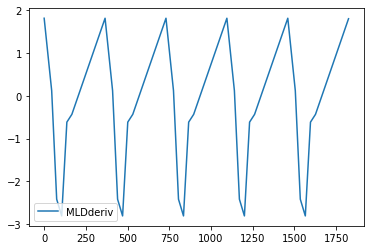

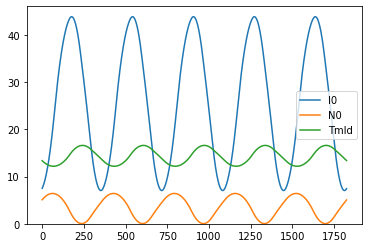

In [13]:
time = odeint_out.Time__time

plt.plot(time, odeint_out.MLD__forcing_value, label='MLD')
plt.ylim(bottom=0)
plt.legend()
plt.show()

plt.plot(time, odeint_out.MLDderiv__forcing_value, label='MLDderiv')
plt.legend()
plt.show()

plt.plot(time, odeint_out.I0__forcing_value, label='I0')
plt.plot(time, odeint_out.N0__forcing_value, label='N0')
plt.plot(time, odeint_out.Tmld__forcing_value, label='Tmld')
plt.ylim(bottom=0)
plt.legend()